In [1]:
# Import helpful libraries
import numpy as np

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the data, and separate the target
iowa_file_path = 'G:\my_lovely_codes\math_model\day10_machine_learning\input\\train.csv'
home_data = pd.read_csv(iowa_file_path)
y = home_data.SalePrice

# Create X (After completing the exercise, you can return to modify this line!)
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd','MSSubClass',
'LotFrontage'
,'LotArea'
,'OverallQual'
,'OverallCond'
,'YearBuilt',
'YearRemodAdd',
'1stFlrSF',
'2ndFlrSF',
'LowQualFinSF',
'GrLivArea',
'FullBath',
'HalfBath',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'Fireplaces',
'WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea',
'MiscVal',
'MoSold',
'YrSold']

# Select columns corresponding to features, and preview the data
X = home_data[features]
X.head()

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

# To improve accuracy, create a new Random Forest model which you will train on all training data
# rf_model_on_full_data = RandomForestRegressor(random_state=1,n_estimators=1000,max_features='log2')
# rf_model_on_full_data.fit(X,y)

from sklearn.model_selection import GridSearchCV

# 定义超参数网格
param_grid = {
    'max_leaf_nodes':np.linspace(5,20000,50).astype(int),
    'max_depth':np.linspace(3,1000,50).astype(int)
}

# 创建基础模型
rf = RandomForestRegressor(random_state=1)

# 实例化GridSearchCV
# scoring='neg_mean_absolute_error'因为GridSearchCV默认寻找最大值，所以使用负MAE
# n_jobs=-1 使用所有可用的CPU核心进行并行计算
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=2)

# 在训练数据上拟合GridSearchCV
# 它会自动处理交叉验证
grid_search.fit(train_X, train_y)

# 获取最佳模型
best_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation MAE on training data: {-grid_search.best_score_:.0f}")

# 新增：使用独立的验证集评估最终模型的性能
val_predictions = best_model.predict(val_X)
final_mae = mean_absolute_error(val_y, val_predictions)
print(f"MAE on hold-out validation data: {final_mae:,.0f}")

# 将结果转换为DataFrame以便可视化
results = pd.DataFrame(grid_search.cv_results_)
results['mae'] = -results['mean_test_score']
# 获取训练分数用于诊断
if 'mean_train_score' in results:
    results['train_mae'] = -results['mean_train_score']
mae_pivot = results.pivot(index='param_max_leaf_nodes', columns='param_max_depth', values='mae')


Validation MAE for Random Forest Model: 18,117
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


C:\Users\12720\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'max_depth': np.int64(23), 'max_leaf_nodes': np.int64(821)}
Best cross-validation MAE on training data: 19634
MAE on hold-out validation data: 18,111


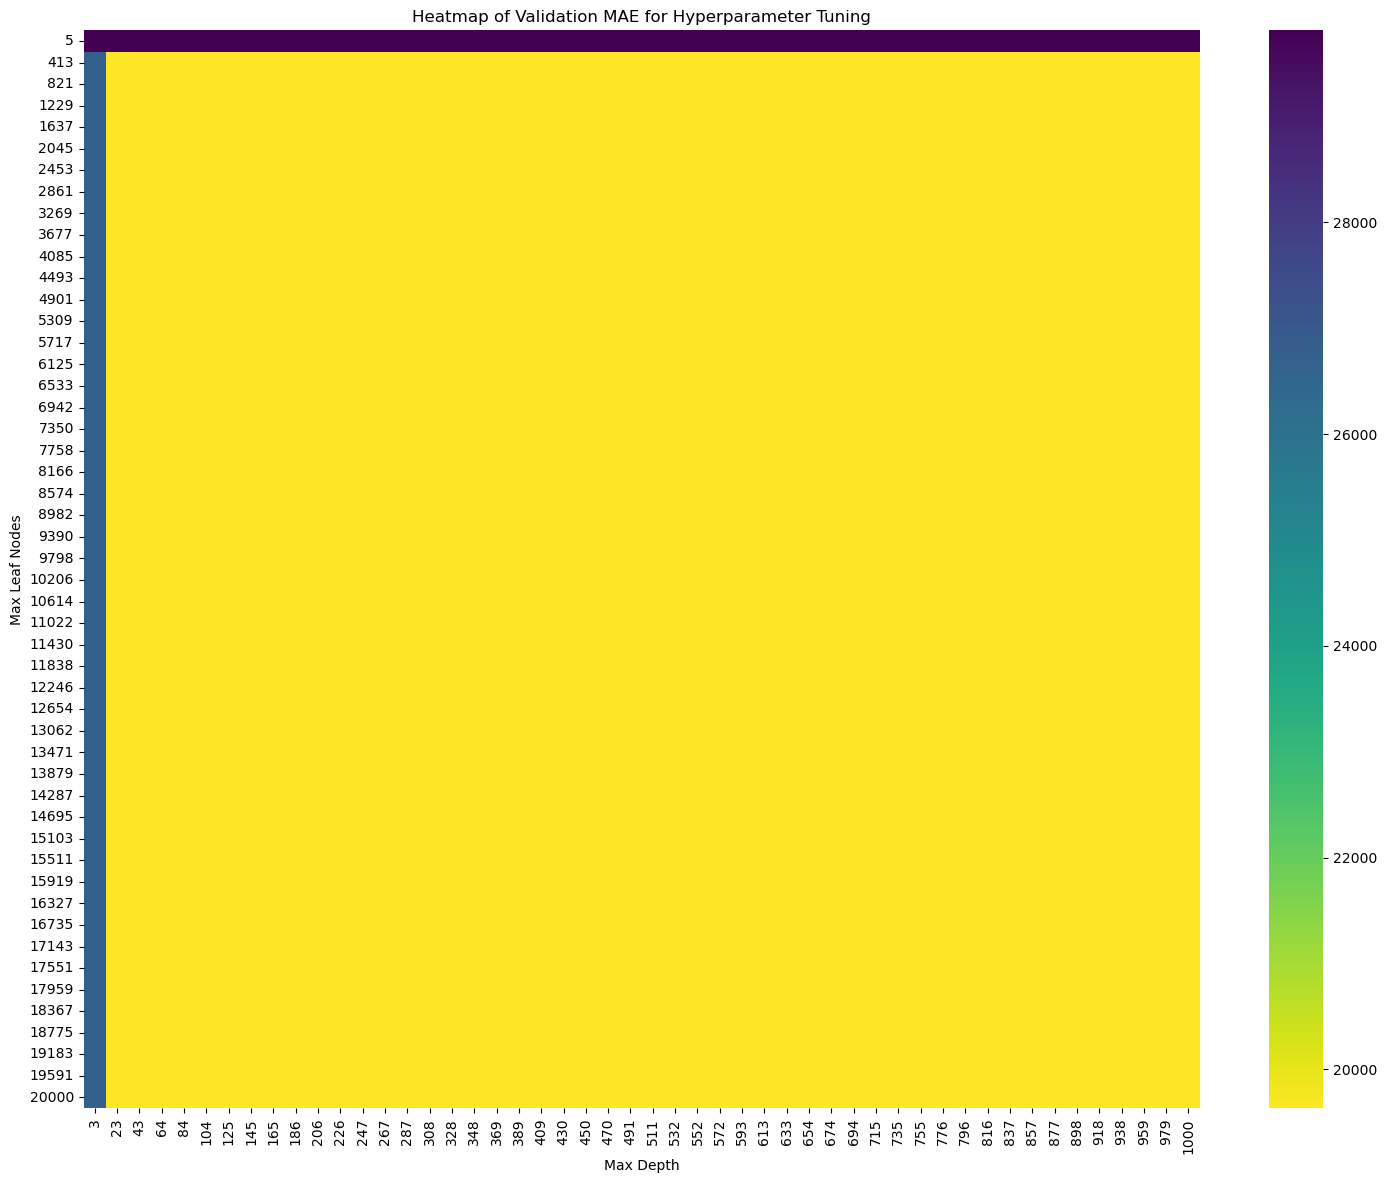

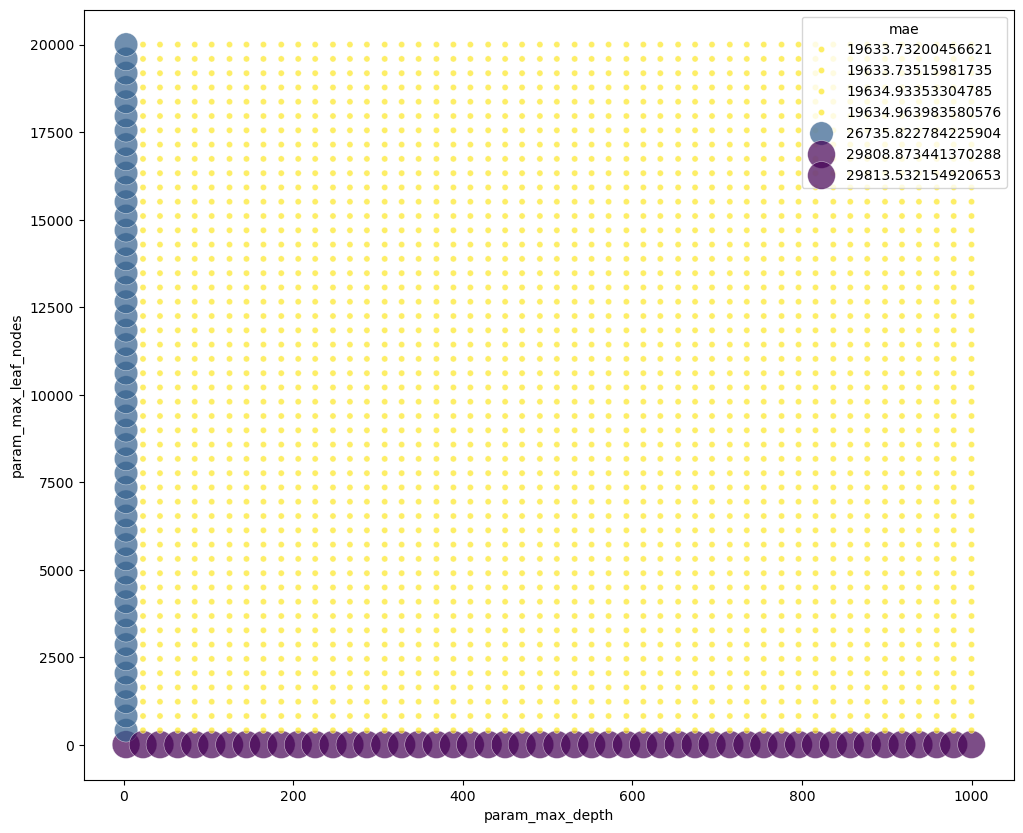

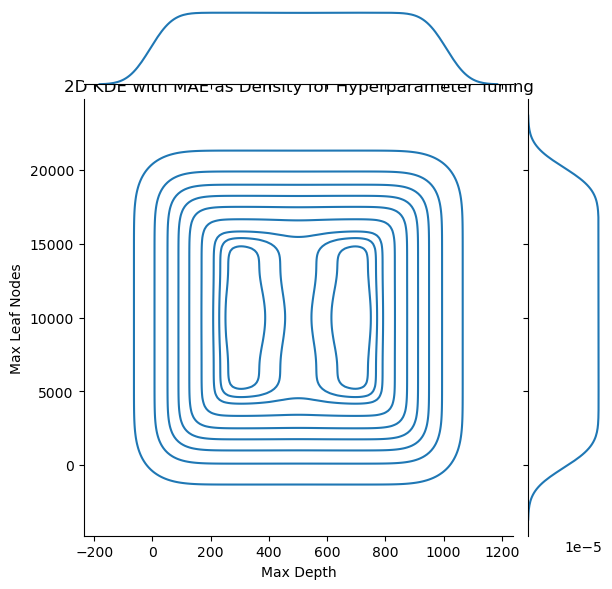

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 可视化部分 --- #

# 1. 使用热力图可视化超参数网格搜索结果
plt.figure(figsize=(18, 14))
sns.heatmap(mae_pivot, annot=False, cmap="viridis_r")
plt.title('Heatmap of Validation MAE for Hyperparameter Tuning')
plt.xlabel('Max Depth')
plt.ylabel('Max Leaf Nodes')
plt.show()

# 2. 绘制学习曲线来观察过拟合
# 检查'train_mae'列是否存在，因为如果GridSearchCV的return_train_score=False，则不会有该列
if 'train_mae' in results:
    # 为了让曲线更平滑，我们按其中一个参数分组，观察另一个参数的影响
    # 按max_leaf_nodes分组，观察max_depth的影响
    plt.figure(figsize=(14, 6))
    
    # 聚合结果，计算每个max_depth对应的平均MAE
    agg_results = results.groupby('param_max_depth').agg({'mae': 'mean', 'train_mae': 'mean'}).reset_index()

    sns.lineplot(data=agg_results, x='param_max_depth', y='mae', label='Average Validation MAE')
    sns.lineplot(data=agg_results, x='param_max_depth', y='train_mae', label='Average Training MAE')

    plt.title('Training vs. Validation MAE across Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# path to file you will use for predictions
test_data_path = 'G:\\my_lovely_codes\\math_model\\day10_machine_learning\\input\\test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

# create test_X which comes from test_data but includes only the columns you used for prediction.
# The list of columns is stored in a variable called features
test_X = test_data.loc[:,features]

# 使用找到的最佳模型进行预测
test_preds = best_model.predict(test_X)

# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

# 3. 尝试使用2D KDE图（结合散点图）来可视化超参数和MAE的关系
# 注意：KDE图本身表示的是密度，将MAE映射到颜色可能需要一些解释
plt.figure(figsize=(12, 10))
# 绘制散点图，用颜色表示MAE
scatter = sns.scatterplot(
    data=results,
    x='param_max_depth',
    y='param_max_leaf_nodes',
    hue='mae', # 使用MAE作为颜色映射
    size='mae', # 也可以使用MAE作为点的大小
    sizes=(20, 400), # 点的大小范围
    palette='viridis_r', # 颜色方案，_r表示反转颜色，让低MAE（好）的颜色更突出
    legend='full',
    alpha=0.7
)
# 在散点图上叠加KDE图，显示参数的密度分布
sns.jointplot(x=results['param_max_depth'], y=results['param_max_leaf_nodes'], kind="kde")
#sns.kdeplot(
#    data=results,
#    x='param_max_depth',
#    y='param_max_leaf_nodes',
#    ax=scatter.axes, # 确保KDE图和散点图在同一个坐标轴上
#    levels=5, # KDE等高线的数量
#    color='black', # 等高线颜色
#    linewidths=1 # 等高线宽度
#)

plt.title('2D KDE with MAE as Density for Hyperparameter Tuning')

plt.xlabel('Max Depth')
plt.ylabel('Max Leaf Nodes')
plt.show()


